In [164]:
pip install pandas-profiling xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [165]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from pandas_profiling import ProfileReport
from xgboost import XGBClassifier
from scipy.stats import boxcox
from sklearn import tree


s3= boto3.resource('s3')
bucket_name= 'morgan-gant-data448-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'Hotel Reservations.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
hotel = pd.read_csv(file_content_stream)
hotel.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

In [166]:
hotel= hotel.drop(columns='Booking_ID')
hotel.head()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             2               0                     1                  2   
1             2               0                     2                  3   
2             1               0                     2                  1   
3             2               0                     0                  2   
4             2               0                     1                  1   

  type_of_meal_plan  required_car_parking_space room_type_reserved  lead_time  \
0       Meal Plan 1                           0        Room_Type 1        224   
1      Not Selected                           0        Room_Type 1          5   
2       Meal Plan 1                           0        Room_Type 1          1   
3       Meal Plan 1                           0        Room_Type 1        211   
4      Not Selected                           0        Room_Type 1         48   

   arrival_year  arrival_month  arrival_date market_segment_type  \
0          2017             10             2             Offline   
1          2018             11             6              Online   
2          2018              2            28              Online   
3          2018              5            20              Online   
4          2018              4            11              Online   

   repeated_guest  no_of_previous_cancellations  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

In [4]:
hotel['booking_status'].value_counts()/hotel.shape[0]
#not balanced, will need to consider this

Not_Canceled    0.672364
Canceled        0.327636
Name: booking_status, dtype: float64

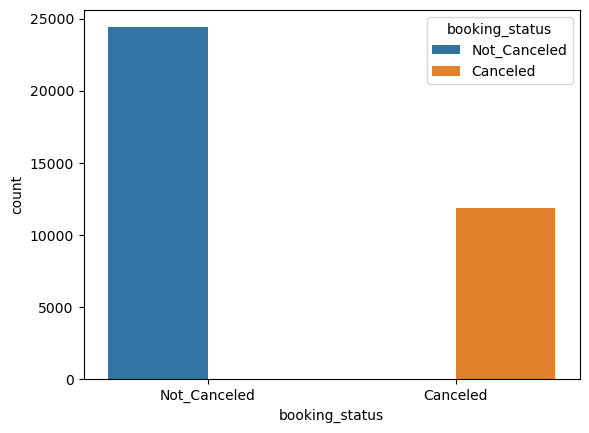

In [5]:
#plot of booking_status 
sns.countplot(x = 'booking_status', hue = 'booking_status', data = hotel);
#As you can see from the chart and frequency statistics, the data is very unbalanced

<AxesSubplot: xlabel='avg_price_per_room', ylabel='Count'>

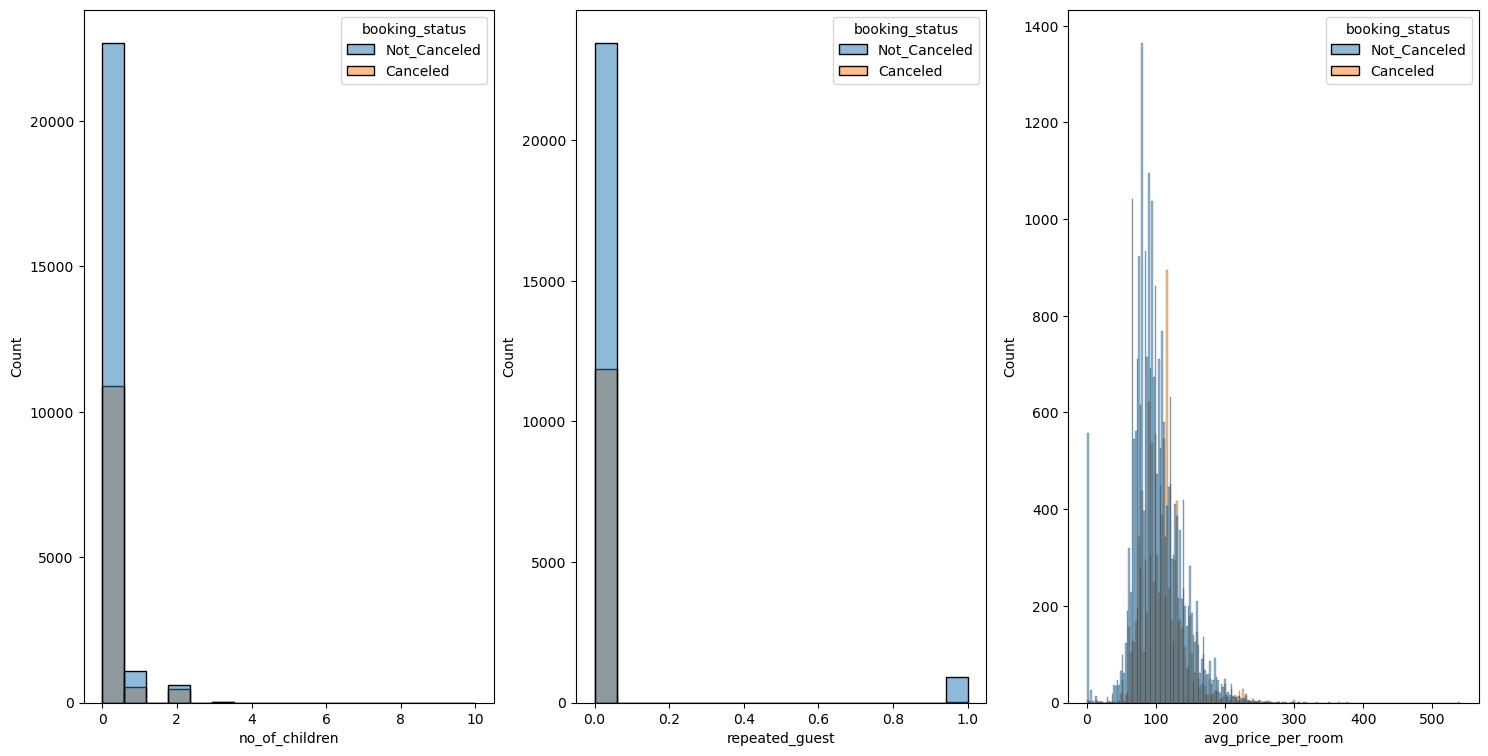

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (18, 9))
sns.histplot(ax = axes[0], x = 'no_of_children', hue = 'booking_status', fill = True, data = hotel)
sns.histplot(ax = axes[1], x = 'repeated_guest', hue = 'booking_status', fill = True, data = hotel)
sns.histplot(ax = axes[2], x = 'avg_price_per_room', hue = 'booking_status', fill = True, data = hotel)

<AxesSubplot: xlabel='no_of_weekend_nights', ylabel='Count'>

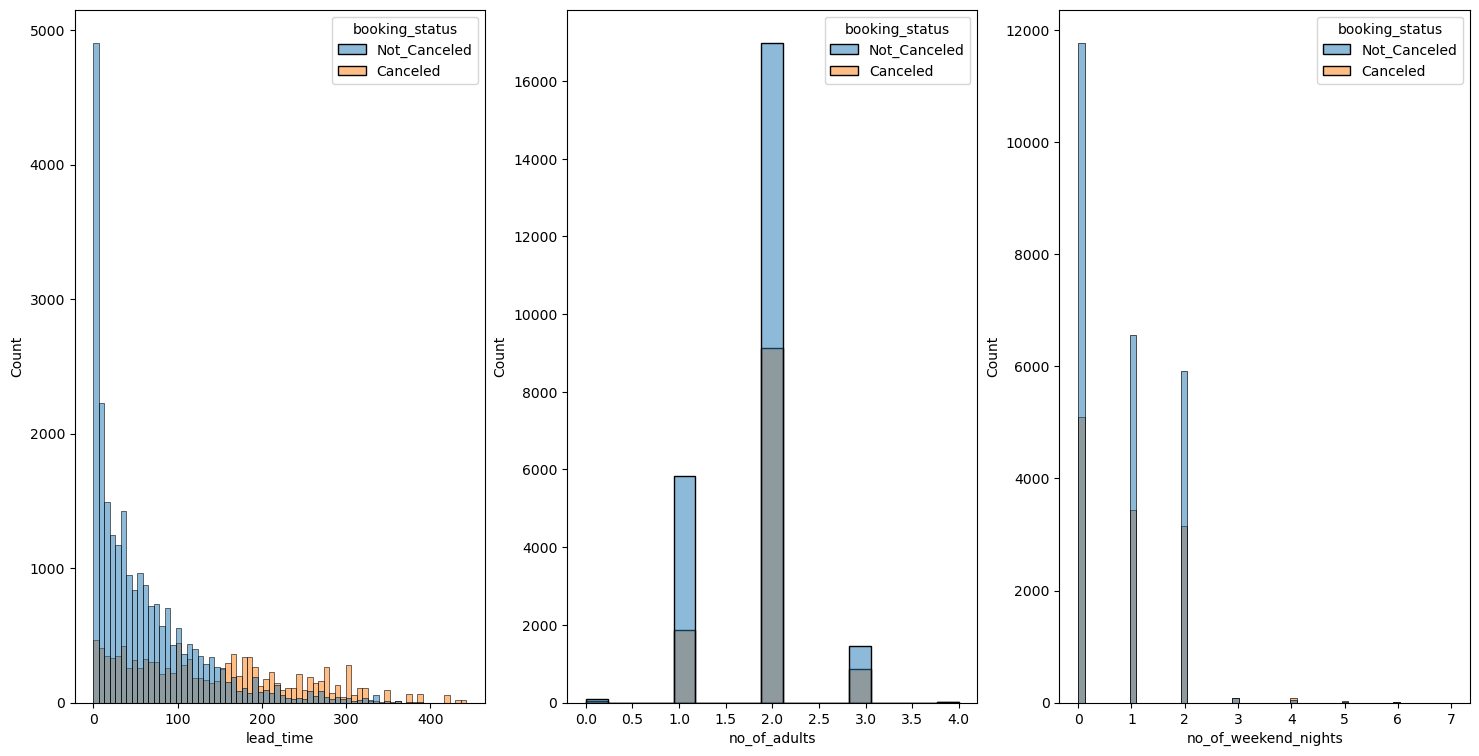

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (18, 9))
sns.histplot(ax = axes[0], x = 'lead_time', hue = 'booking_status', fill = True, data = hotel)
sns.histplot(ax = axes[1], x = 'no_of_adults', hue = 'booking_status', fill = True, data = hotel)
sns.histplot(ax = axes[2], x = 'no_of_weekend_nights', hue = 'booking_status', fill = True, data = hotel)

In [8]:
hotel.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [167]:
# Splitting the data into training and testing sets
train, test= train_test_split(hotel, test_size=0.2, stratify= hotel['booking_status'])

In [168]:
train = train.replace(to_replace = ['Canceled','Not_Canceled'],value = ['1','0'])

test = test.replace(to_replace = ['Canceled','Not_Canceled'],value = ['1','0'])

In [169]:
#changing to dummy variables
train= pd.concat([train.drop(columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type' ], axis=1), pd.get_dummies(train[['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']])], axis=1)

test= pd.concat([test.drop(columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type' ], axis=1), pd.get_dummies(test[['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']])], axis=1)

In [12]:
#checking for importance features through random forest
importances= list()
for i in range (0,100):
    # Defining the input and target variables
    x= train.drop(columns='booking_status', axis=1)
    y= train['booking_status']

    #Splitting the data
    x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify= y)

    #Building Model
    rf_md= RandomForestClassifier(n_estimators= 500, max_depth=3).fit(x_train, y_train)
    #Extracting the feature importances
    importances.append(rf_md.feature_importances_)

In [13]:
#Computing averages of features
rf = pd.DataFrame(importances)
rf.columns= ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests',
       'type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2',
       'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected',
       'room_type_reserved_Room_Type 1', 'room_type_reserved_Room_Type 2',
       'room_type_reserved_Room_Type 3', 'room_type_reserved_Room_Type 4',
       'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6',
       'room_type_reserved_Room_Type 7', 'market_segment_type_Aviation',
       'market_segment_type_Complementary', 'market_segment_type_Corporate',
       'market_segment_type_Offline', 'market_segment_type_Online']
rf.apply(np.mean, axis = 0).sort_values(ascending = False)

lead_time                               3.770999e-01
no_of_special_requests                  1.685402e-01
avg_price_per_room                      1.022637e-01
arrival_year                            9.649824e-02
arrival_month                           5.702805e-02
market_segment_type_Online              4.473313e-02
market_segment_type_Corporate           2.673183e-02
type_of_meal_plan_Meal Plan 2           1.979615e-02
repeated_guest                          1.975561e-02
market_segment_type_Offline             1.470069e-02
no_of_previous_bookings_not_canceled    1.465205e-02
no_of_adults                            1.344220e-02
required_car_parking_space              1.154465e-02
no_of_week_nights                       1.086613e-02
no_of_weekend_nights                    6.202945e-03
type_of_meal_plan_Meal Plan 1           3.886845e-03
market_segment_type_Complementary       3.781597e-03
arrival_date                            2.824954e-03
type_of_meal_plan_Not Selected          1.3397

In [170]:
#Interactions based off top 3 importances
#Engineering interactions based on feature importance
train['interaction_1']= train['lead_time'] * train['no_of_special_requests']
train['interaction_2']= train['lead_time'] * train['avg_price_per_room']
train['interaction_3']= train['avg_price_per_room'] * train['no_of_special_requests']

test['interaction_1']= test['lead_time'] * test['no_of_special_requests']
test['interaction_2']= test['lead_time'] * test['avg_price_per_room']
test['interaction_3']= test['avg_price_per_room'] * test['no_of_special_requests']

In [ ]:
#Can not use due to there being zeros in the column because the logarithmic function used in the transformation is not defined for these values.
#BoxCox transformation
transformed_lead_time= boxcox(hotel['lead_time'])
hotel['lead_time'] = transformed_lead_time[0]
hotel.head

In [171]:
# x^2
train['lead_time^2']= np.square(train['lead_time'])

test['lead_time^2']= np.square(test['lead_time'])

In [172]:
# no_of_weekend_nights^3
train['no_of_weekend_nights^3']=  np.power(train['no_of_weekend_nights'], 3)

test['no_of_weekend_nights^3']=  np.power(test['no_of_weekend_nights'], 3)

In [173]:
#parent to child ratio
train['par_child']= train['no_of_adults'] * train['no_of_children']

test['par_child']= test['no_of_adults'] * test['no_of_children']

In [174]:
#difference in week nights and weekened nights
train['diff_night']= train['no_of_weekend_nights']- train['no_of_week_nights']

test['diff_night']= test['no_of_weekend_nights']- test['no_of_week_nights']

[Text(0.5, 0.875, 'interaction_2 <= 16793.365\ngini = 0.441\nsamples = 23216\nvalue = [15610, 7606]'),
 Text(0.25, 0.625, 'no_of_special_requests <= 0.5\ngini = 0.361\nsamples = 19230\nvalue = [14690, 4540]'),
 Text(0.125, 0.375, 'market_segment_type_Online <= 0.5\ngini = 0.447\nsamples = 10232\nvalue = [6787, 3445]'),
 Text(0.0625, 0.125, 'gini = 0.266\nsamples = 5332\nvalue = [4491, 841]'),
 Text(0.1875, 0.125, 'gini = 0.498\nsamples = 4900\nvalue = [2296, 2604]'),
 Text(0.375, 0.375, 'interaction_2 <= 4663.975\ngini = 0.214\nsamples = 8998\nvalue = [7903, 1095]'),
 Text(0.3125, 0.125, 'gini = 0.138\nsamples = 4992\nvalue = [4619, 373]'),
 Text(0.4375, 0.125, 'gini = 0.295\nsamples = 4006\nvalue = [3284, 722]'),
 Text(0.75, 0.625, 'avg_price_per_room <= 99.97500000000001\ngini = 0.355\nsamples = 3986\nvalue = [920, 3066]'),
 Text(0.625, 0.375, 'no_of_adults <= 1.5\ngini = 0.47700000000000004\nsamples = 1464\nvalue = [576, 888]'),
 Text(0.5625, 0.125, 'gini = 0.364\nsamples = 301\nval

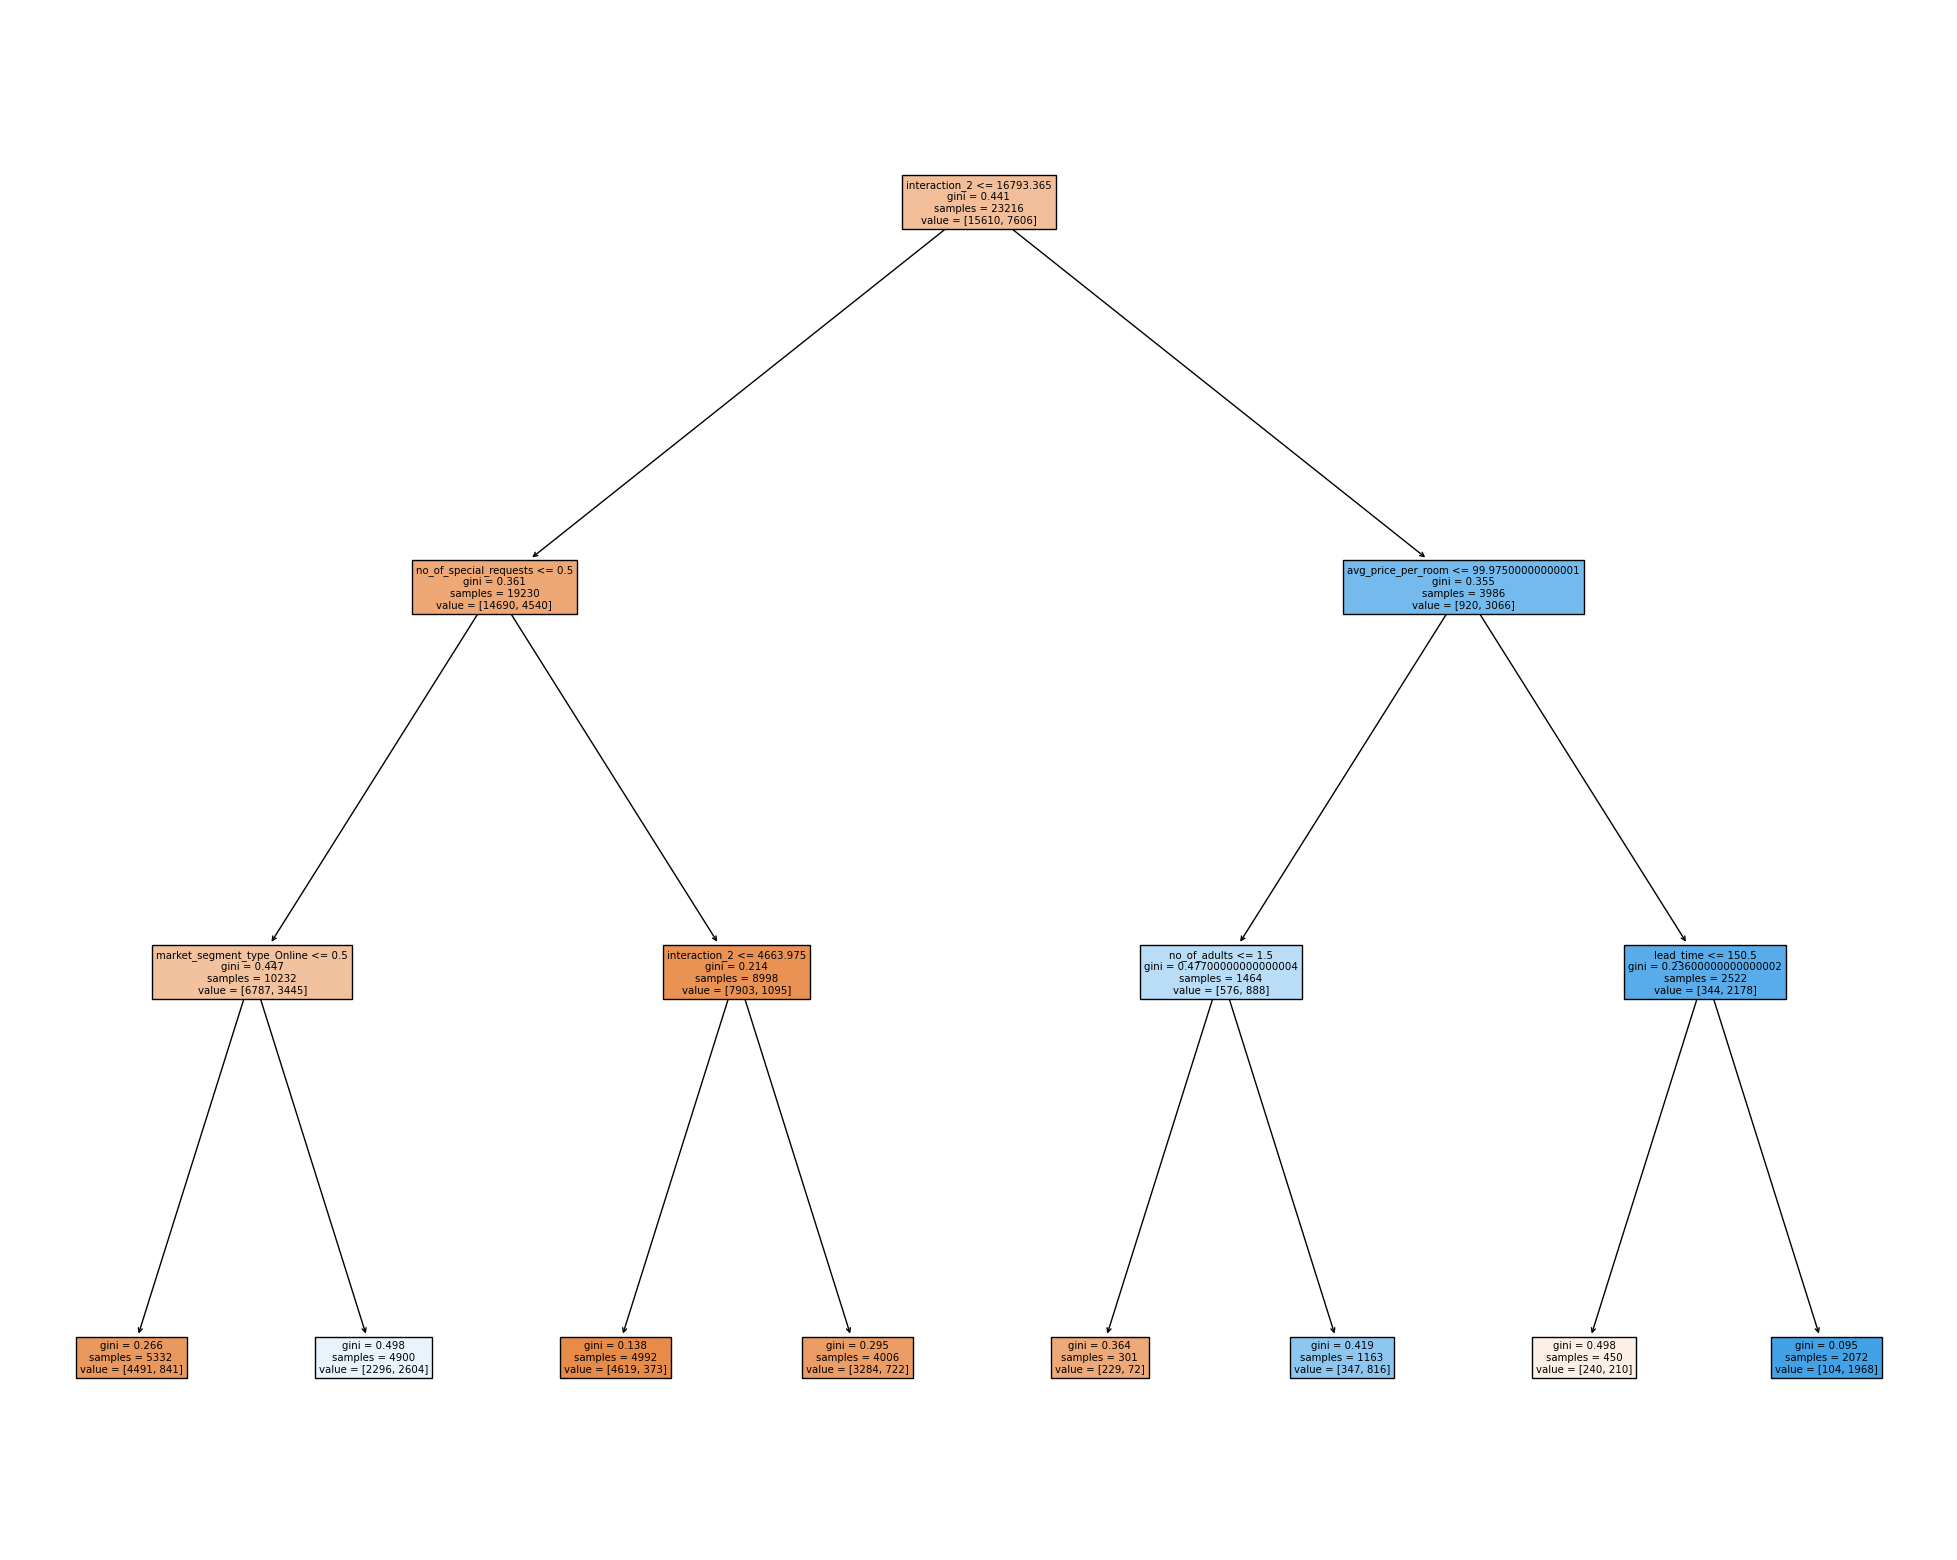

In [175]:
#1
# Defining the input and target variables
x= train.drop(columns= 'booking_status', axis=1)
y= train['booking_status']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

#building decison tree
tree_md= DecisionTreeClassifier(max_depth= 3).fit(x_train, y_train)
fig=plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names= x_train.columns, filled=True)

[Text(0.5, 0.875, 'interaction_2 <= 16793.365\ngini = 0.441\nsamples = 23216\nvalue = [15610, 7606]'),
 Text(0.25, 0.625, 'no_of_special_requests <= 0.5\ngini = 0.36\nsamples = 19248\nvalue = [14720, 4528]'),
 Text(0.125, 0.375, 'market_segment_type_Online <= 0.5\ngini = 0.446\nsamples = 10248\nvalue = [6803, 3445]'),
 Text(0.0625, 0.125, 'gini = 0.268\nsamples = 5375\nvalue = [4520, 855]'),
 Text(0.1875, 0.125, 'gini = 0.498\nsamples = 4873\nvalue = [2283, 2590]'),
 Text(0.375, 0.375, 'interaction_2 <= 4663.975\ngini = 0.212\nsamples = 9000\nvalue = [7917, 1083]'),
 Text(0.3125, 0.125, 'gini = 0.136\nsamples = 4996\nvalue = [4630, 366]'),
 Text(0.4375, 0.125, 'gini = 0.294\nsamples = 4004\nvalue = [3287, 717]'),
 Text(0.75, 0.625, 'avg_price_per_room <= 99.97500000000001\ngini = 0.34800000000000003\nsamples = 3968\nvalue = [890, 3078]'),
 Text(0.625, 0.375, 'no_of_adults <= 1.5\ngini = 0.47200000000000003\nsamples = 1457\nvalue = [555, 902]'),
 Text(0.5625, 0.125, 'gini = 0.399\nsampl

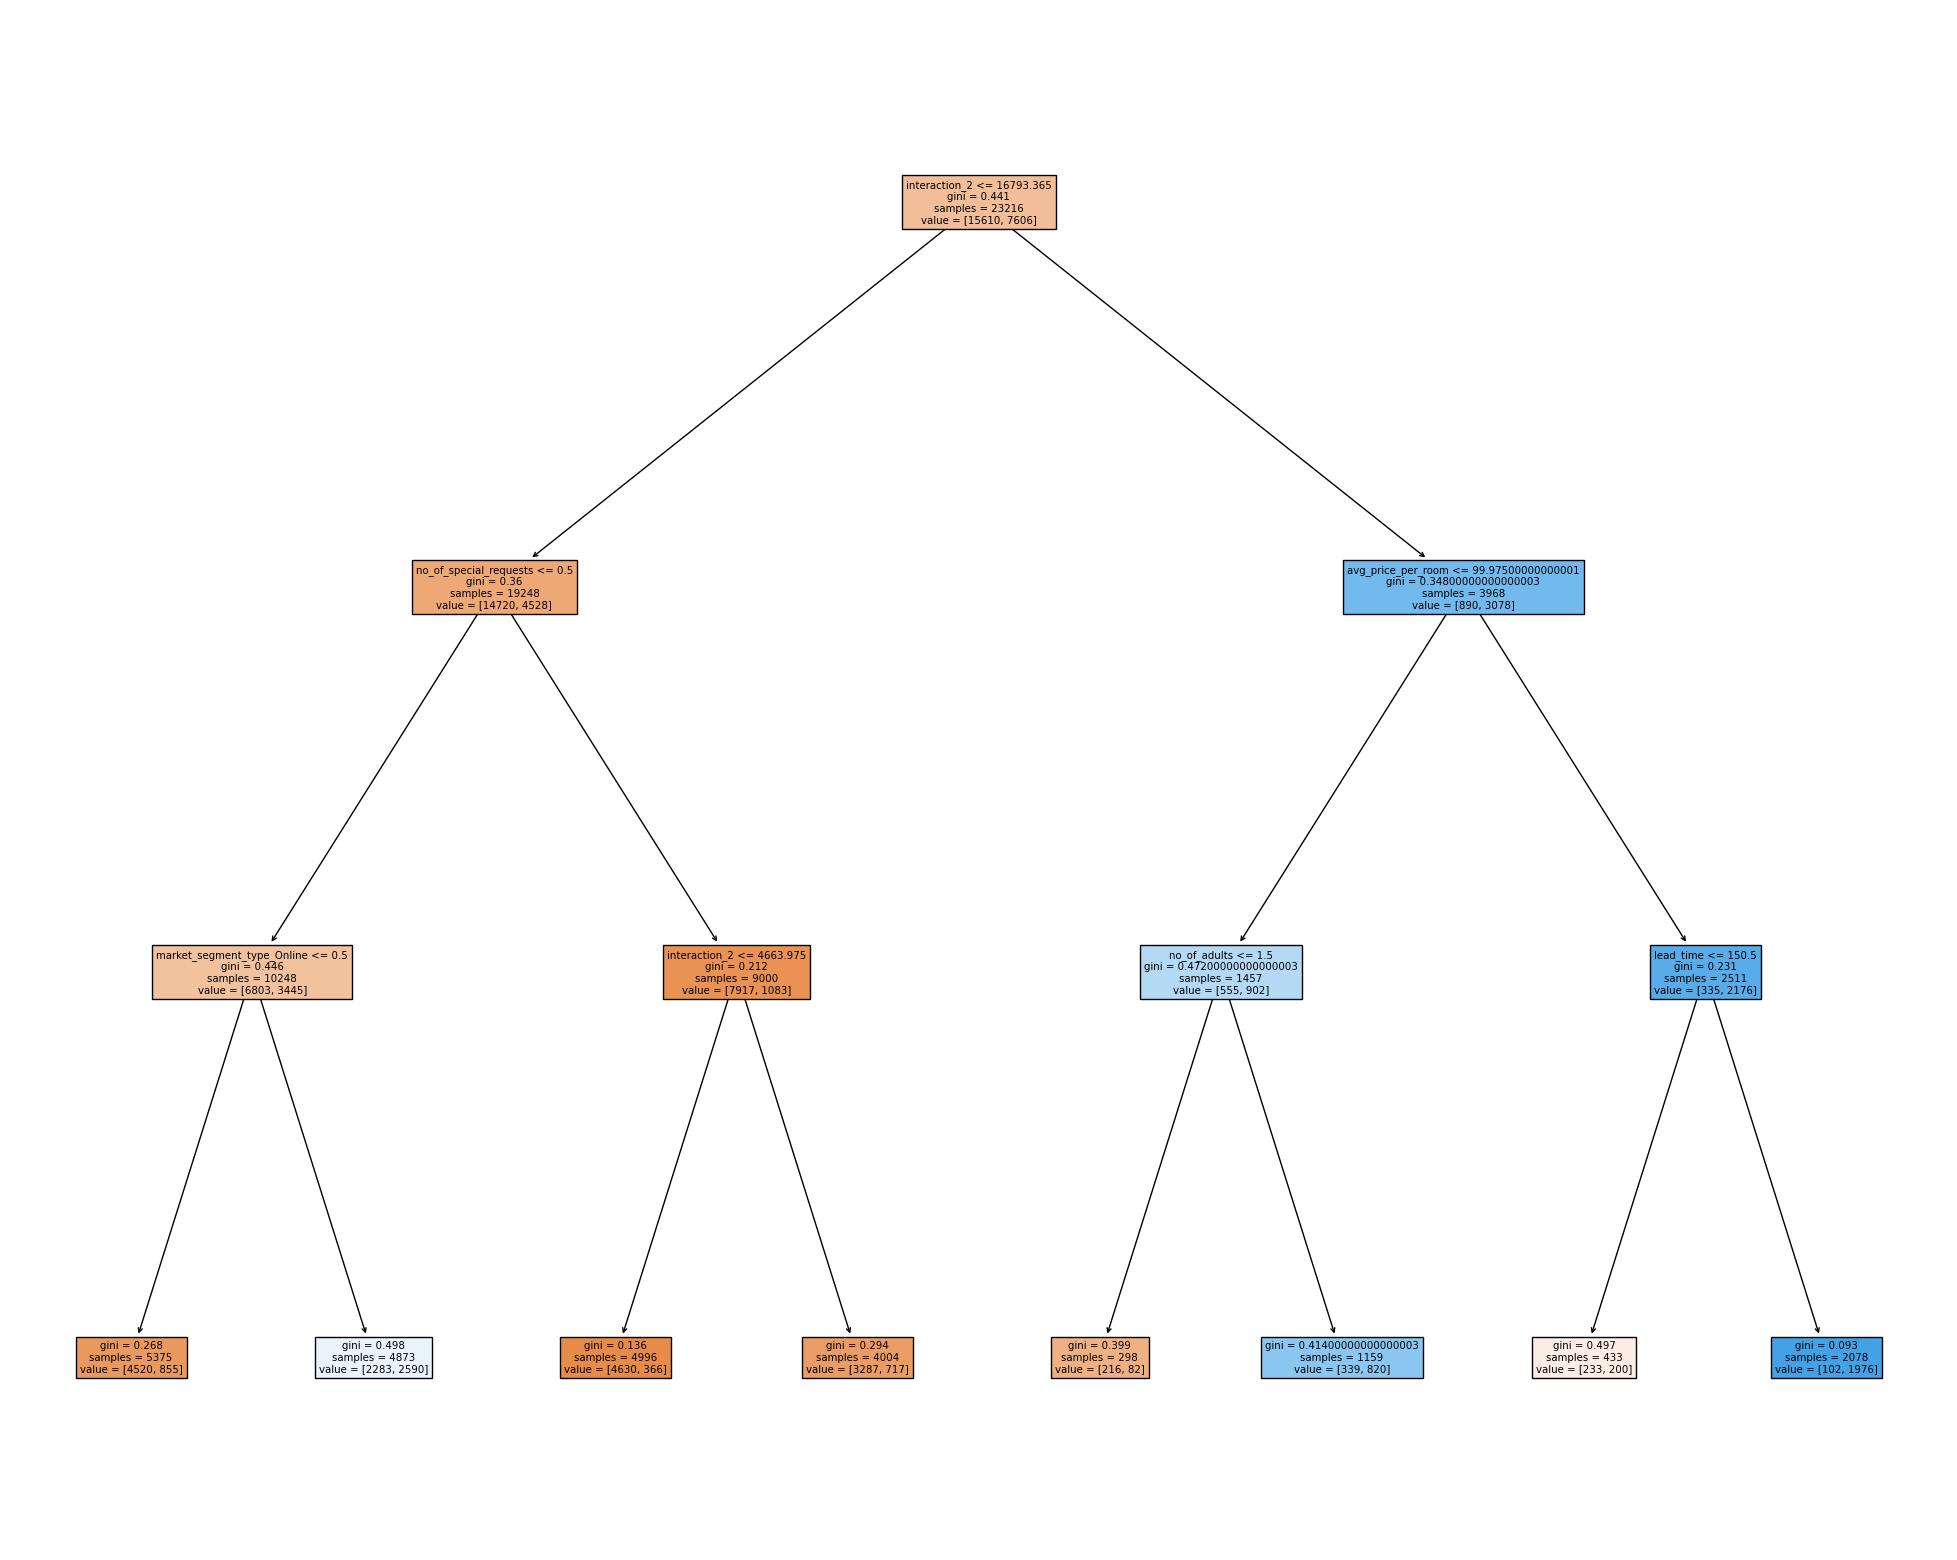

In [176]:
#2
# Defining the input and target variables
x= train.drop(columns= 'booking_status', axis=1)
y= train['booking_status']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

#building decison tree
tree_md= DecisionTreeClassifier(max_depth= 3).fit(x_train, y_train)
fig=plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names= x_train.columns, filled=True)

In [177]:
#engineering features from the decisoon tree model
train['interaction_4']=np.where((train['interaction_2'] <= 16793.365) &
                                   (train['no_of_special_requests'] < .5)&
                                    (train['market_segment_type_Online'] <= .5), 1,0)

test['interaction_4']=np.where((test['interaction_2'] <= 16793.365) &
                                   (test['no_of_special_requests'] < .5)&
                                    (test['market_segment_type_Online'] <= .5), 1,0)

In [20]:
# Defining the input and target variables
x= hotel.drop(columns= 'booking_status', axis=1)
y= hotel['booking_status']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

In [ ]:
#running RFE with Random forest model
rf_rfe = RFE(estimator = RandomForestClassifier(n_estimators = 500, max_depth = 3), n_features_to_select = 10).fit(x_train, y_train)

#extracting feature names 
print(x_train.columns[rf_rfe.support_])

In [24]:
hotel.head()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             2               0                     1                  2   
1             2               0                     8                  3   
2             1               0                     8                  1   
3             2               0                     0                  2   
4             2               0                     1                  1   

   required_car_parking_space  lead_time  arrival_year  arrival_month  \
0                           0        224          2017             10   
1                           0          5          2018             11   
2                           0          1          2018              2   
3                           0        211          2018              5   
4                           0         48          2018              4   

   arrival_date  repeated_guest  ...  market_segment_type_Corporate  \
0             2               0  ...                              0   
1             6               0  ...                              0   
2            28               0  ...                              0   
3            20               0  ...                              0   
4            11               0  ...                              0   

   market_segment_type_Offline  market_segment_type_Online  interaction_1  \
0                            1                           0              0   
1                            0                           1              5   
2                            0                           1              0   
3                            0                           1              0   
4                            0                           1              0   

  interaction_2  interaction_3  lead_time^2  par_child  diff_night  \
0       14560.0           0.00        50176          0          -1   
1         533.4         106.68           25          0           5   
2          60.0           0.00            1          0           7   
3       21100.0           0.00        44521          0          -2   
4        4536.0           0.00         2304          0           0   

   interaction_4  
0              1  
1              0  
2              0  
3              0  
4              0  

[5 rows x 38 columns]

In [31]:
from tqdm.notebook import tqdm

rf= list()
xgb= list
gb= list()

for i in tqdm(range(0,20)):
    
    #Defining input and target variables
    x= train.drop(columns= 'booking_status', axis=1)
    y= train['booking_status']
  
    
    #running RFECV with Random forest model
    rf_rfecv = RFECV(estimator = RandomForestClassifier(n_estimators = 100, max_depth = 3), step= 3, min_features_to_select= 2, cv= 5).fit(x, y)
    #appending rankings
    rf.append(rf_rfecv.support_)
    
    
    #running RFE with xgb model
    xgb_rfecv = RFECV(estimator = XGBClassifier(n_estimators = 100, max_depth = 3), step= 3, min_features_to_select= 2, cv= 5).fit(x, y)
    #appending rankings
    xgb.append(xgb_rfecv.support_)
    
    
    #running RFE with xgb model
    gb_rfecv = RFECV(estimator = GradientBoostingClassifier(n_estimators = 100, max_depth = 3), step= 3, min_features_to_select= 2, cv= 5).fit(x, y)
    #appending rankings
    gb.append(gb_rfecv.support_)

    
    print(i)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from tqdm.notebook import tqdm

rf = []
xgb = []
gb = []

for i in tqdm(range(0, 10)):
    
    #Defining input and target variables
    x = train.drop(columns='booking_status', axis=1)
    y = train['booking_status'].astype(int)
    
    #running RFECV with Random forest model
    rf_rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=100, max_depth=3), step=3, min_features_to_select=2, cv=5).fit(x, y)
    
    #appending rankings
    rf.append(rf_rfecv.support_.tolist())   # convert numpy array to list using tolist() method
    
    #running RFE with xgb model
    xgb_rfecv = RFECV(estimator=XGBClassifier(n_estimators=100, max_depth=3), step=3, min_features_to_select=2, cv=5).fit(x, y)
    
    #appending rankings
    xgb.append(xgb_rfecv.support_.tolist())   # convert numpy array to list using tolist() method
    
    #running RFE with gb model
    gb_rfecv = RFECV(estimator=GradientBoostingClassifier(n_estimators=100, max_depth=3), step=3, min_features_to_select=2, cv=5).fit(x, y)
    
    #appending rankings
    gb.append(gb_rfecv.support_.tolist())   # convert numpy array to list using tolist() method
    
    print(i)


  0%|          | 0/10 [00:00<?, ?it/s]

0
4
5
6
7
9


In [18]:
rf= pd.DataFrame(rf)
rf.columns=x.columns
100*rf.apply(np.sum, axis=0)/rf.shape[0]

no_of_adults                              0.0
no_of_children                            0.0
no_of_weekend_nights                      0.0
no_of_week_nights                         0.0
required_car_parking_space                0.0
lead_time                               100.0
arrival_year                            100.0
arrival_month                            30.0
arrival_date                              0.0
repeated_guest                            0.0
no_of_previous_cancellations              0.0
no_of_previous_bookings_not_canceled      0.0
avg_price_per_room                      100.0
no_of_special_requests                  100.0
type_of_meal_plan_Meal Plan 1             0.0
type_of_meal_plan_Meal Plan 2             0.0
type_of_meal_plan_Meal Plan 3             0.0
type_of_meal_plan_Not Selected            0.0
room_type_reserved_Room_Type 1            0.0
room_type_reserved_Room_Type 2            0.0
room_type_reserved_Room_Type 3            0.0
room_type_reserved_Room_Type 4    

In [19]:
xgb= pd.DataFrame(xgb)
xgb.columns=x.columns
100*xgb.apply(np.sum, axis=0)/xgb.shape[0]

no_of_adults                            100.0
no_of_children                            0.0
no_of_weekend_nights                    100.0
no_of_week_nights                       100.0
required_car_parking_space              100.0
lead_time                               100.0
arrival_year                            100.0
arrival_month                           100.0
arrival_date                              0.0
repeated_guest                          100.0
no_of_previous_cancellations              0.0
no_of_previous_bookings_not_canceled    100.0
avg_price_per_room                      100.0
no_of_special_requests                  100.0
type_of_meal_plan_Meal Plan 1             0.0
type_of_meal_plan_Meal Plan 2           100.0
type_of_meal_plan_Meal Plan 3             0.0
type_of_meal_plan_Not Selected          100.0
room_type_reserved_Room_Type 1            0.0
room_type_reserved_Room_Type 2            0.0
room_type_reserved_Room_Type 3            0.0
room_type_reserved_Room_Type 4    

In [20]:
gb= pd.DataFrame(gb)
gb.columns=x.columns
100*gb.apply(np.sum, axis=0)/gb.shape[0]

no_of_adults                            100.0
no_of_children                            0.0
no_of_weekend_nights                    100.0
no_of_week_nights                       100.0
required_car_parking_space              100.0
lead_time                               100.0
arrival_year                            100.0
arrival_month                           100.0
arrival_date                            100.0
repeated_guest                            0.0
no_of_previous_cancellations              0.0
no_of_previous_bookings_not_canceled      0.0
avg_price_per_room                      100.0
no_of_special_requests                  100.0
type_of_meal_plan_Meal Plan 1           100.0
type_of_meal_plan_Meal Plan 2             0.0
type_of_meal_plan_Meal Plan 3             0.0
type_of_meal_plan_Not Selected          100.0
room_type_reserved_Room_Type 1            0.0
room_type_reserved_Room_Type 2            0.0
room_type_reserved_Room_Type 3            0.0
room_type_reserved_Room_Type 4    

In [21]:
models = pd.concat([rf, xgb, gb])

In [22]:
column_means = models.mean(axis=0)
column_means*100

no_of_adults                             66.666667
no_of_children                            0.000000
no_of_weekend_nights                     66.666667
no_of_week_nights                        66.666667
required_car_parking_space               66.666667
lead_time                               100.000000
arrival_year                            100.000000
arrival_month                            76.666667
arrival_date                             33.333333
repeated_guest                           33.333333
no_of_previous_cancellations              0.000000
no_of_previous_bookings_not_canceled     33.333333
avg_price_per_room                      100.000000
no_of_special_requests                  100.000000
type_of_meal_plan_Meal Plan 1            33.333333
type_of_meal_plan_Meal Plan 2            33.333333
type_of_meal_plan_Meal Plan 3             0.000000
type_of_meal_plan_Not Selected           66.666667
room_type_reserved_Room_Type 1            0.000000
room_type_reserved_Room_Type 2 

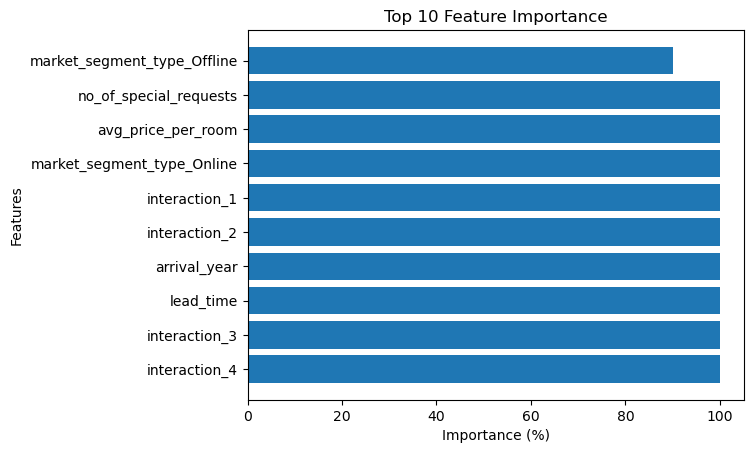

In [23]:
import matplotlib.pyplot as plt

# calculate the mean feature importance across all models
column_means = models.mean(axis=0)

# sort the feature importance values and take the top 10
top10 = column_means.sort_values(ascending=False).head(10)

# create a bar chart
plt.barh(top10.index, top10.values*100)

# set chart title and axis labels
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance (%)')
plt.ylabel('Features')

# show the plot
plt.show()

In [27]:
# Defining the input and target variables
x= train.drop(columns= 'booking_status', axis=1)
y= train['booking_status']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

In [178]:
#defining variables
x= train[['interaction_4', 'interaction_3', 'interaction_2', 'interaction_1', 'market_segment_type_Online', 
               'no_of_special_requests', 'avg_price_per_room', 'lead_time', 'arrival_year']]
y= train['booking_status']

In [179]:
from sklearn.preprocessing import LabelEncoder


# convert y to numeric values
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)

In [180]:
from sklearn.metrics import f1_score
from precision_recall_cutoff import precision_recall_cutoff

Grid Search CV

In [25]:
xgb_param_grid = {'n_estimators': [500],
'max_depth': [3, 5, 7],
'min_child_weight': [5, 7],
'learning_rate': [0.01],
'gamma': [0.3, 0.1],
'subsample': [0.8, 1],
'colsample_bytree': [1]}

#runnning gridsearchCV
xgb_grid_search= GridSearchCV(estimator= XGBClassifier(), param_grid= xgb_param_grid, cv= 3, scoring= 'f1', n_jobs=-1).fit(x, y)
    
#Extracting best hyperparamter combo
xgb_md_gs= xgb_grid_search.best_params_
xgb_score_gs= xgb_grid_search.best_score_


print('Best hyper-parameter combo', xgb_md_gs)
print('Best score:', xgb_score_gs)

Best hyper-parameter combo {'colsample_bytree': 1, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}
Best score: 0.7798732818274288


In [36]:
#building a random forest with best parameters
xgb= XGBClassifier(**xgb_grid_search.best_params_).fit(x_train, y_train)

#predicting on the test
xgb_pred= xgb.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
xgb_label = np.where(xgb_pred < 0.1, 0, 1)

# computing the F1 score
xgb_f1 = f1_score(y_test, xgb_label)

# printing the F1 score
print("F1 score:", xgb_f1)

F1 score: 0.672779575692197


In [31]:
rf_param_grid = {'n_estimators': [100, 300, 500],
'min_samples_split': [10, 15],
'min_samples_leaf': [5, 7],
'max_depth' : [3, 5, 7]}

#runnning gridsearchCV
rf_grid_search= GridSearchCV(estimator= RandomForestClassifier(), param_grid= rf_param_grid, cv= 5, scoring= 'f1').fit(x_train, y_train)
    
#Extracting best hyperparamter combo
rf_md= rf_grid_search.best_params_
rf_score_gs= rf_grid_search.best_score_


print('Best hyper-parameter combo', rf_md)
print('Best score:', rf_score_gs)

Best hyper-parameter combo {'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.7517748411427572


In [79]:
#building a random forest with best parameters
rf= RandomForestClassifier(**rf_grid_search.best_params_).fit(x_train, y_train)

#predicting on the test
rf_pred= rf.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
rf_label = np.where(rf_pred < 0.1, 0, 1)

# computing the F1 score
rf_f1 = f1_score(y_test, rf_label)

# printing the F1 score
print("F1 score:", rf_f1)

F1 score: 0.6180789438232521


In [206]:
gb_param_grid = {'n_estimators': [500],
'max_depth': [3, 5, 7],
'min_samples_split': [10, 15],
'min_samples_leaf': [5, 7],
'learning_rate': [0.01]}



#runnning gridsearchCV
gb_grid_search= GridSearchCV(estimator= GradientBoostingClassifier(), param_grid= gb_param_grid, cv= 3, scoring= 'f1', n_jobs=-1).fit(x_train, y_train)
    
#Extracting best hyperparamter combo
gb_md= gb_grid_search.best_params_
gb_score_gs= gb_grid_search.best_score_


print('Best hyper-parameter combo', gb_md)
print('Best score:', gb_score_gs)

KeyboardInterrupt: 

In [38]:
#building a random forest with best parameters
gb= GradientBoostingClassifier(**gb_grid_search.best_params_).fit(x_train, y_train)

#predicting on the test
gb_pred= gb.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
gb_label = np.where(gb_pred < 0.1, 0, 1)

# computing the F1 score
gb_f1 = f1_score(y_test, gb_label)

# printing the F1 score
print("F1 score:", gb_f1)

F1 score: 0.6863033873343152


Randomized Search CV

In [34]:
xgb_param_grid = {'n_estimators': [500],
'max_depth': [3, 5, 7],
'min_child_weight': [5, 7],
'learning_rate': [0.01],
'gamma': [0.3, 0.1],
'subsample': [0.8, 1],
'colsample_bytree': [1]}

#runnning gridsearchCV
xgb_rscv= RandomizedSearchCV(estimator= XGBClassifier(), param_distributions= xgb_param_grid, cv= 3, scoring= 'f1', n_jobs=-1, n_iter=10).fit(x_train, y_train)
    
#Extracting best hyperparamter combo
xgb_md_rscv= xgb_rscv.best_params_
xgb_score_rs= xgb_rscv.best_score_


print('Best hyper-parameter combo', xgb_md_rscv)
print('Best score:', xgb_score_rs)

Best hyper-parameter combo {'subsample': 1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1}
Best score: 0.7818059131206051


In [90]:
#building a random forest with best parameters
xgb_rs= XGBClassifier(**xgb_rscv.best_params_).fit(x_train, y_train)

#predicting on the test
xgb_pred_rs= xgb_rs.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
xgb_label_rs = np.where(xgb_pred_rs < 0.1, 0, 1)

# computing the F1 score
xgb_f1_rs = f1_score(y_test, xgb_label_rs)

# printing the F1 score
print("F1 score:", xgb_f1_rs)

F1 score: 0.6361613351877607


In [35]:
rf_param_grid = {'n_estimators': [100, 300, 500],
'min_samples_split': [10, 15],
'min_samples_leaf': [5, 7],
'max_depth' : [3, 5, 7]}

#runnning gridsearchCV
rf_rscv= RandomizedSearchCV(estimator= RandomForestClassifier(), param_distributions= rf_param_grid, cv= 5, scoring= 'f1', n_jobs=-1, n_iter=10).fit(x_train, y_train)
    
#Extracting best hyperparamter combo
rf_md_rscv= rf_rscv.best_params_
rf_score_rs= rf_rscv.best_score_


print('Best hyper-parameter combo', rf_md_rscv)
print('Best score:', rf_score_rs)

Best hyper-parameter combo {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_depth': 7}
Best score: 0.7483543503335299


In [93]:
#building a random forest with best parameters
rf_rs= RandomForestClassifier(**rf_rscv.best_params_).fit(x_train, y_train)

#predicting on the test
rf_pred_rs= rf_rs.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
rf_label_rs = np.where(rf_pred_rs < 0.1, 0, 1)

# computing the F1 score
rf_f1_rs = f1_score(y_test, rf_label_rs)

# printing the F1 score
print("F1 score:", rf_f1_rs)

F1 score: 0.615652640042884


In [36]:
gb_param_grid = {'n_estimators': [500],
'max_depth': [3, 5, 7],
'min_samples_split': [10, 15],
'min_samples_leaf': [5, 7],
'learning_rate': [0.01]}


#runnning gridsearchCV
gb_rscv= RandomizedSearchCV(estimator= GradientBoostingClassifier(), param_distributions= gb_param_grid, cv= 3, scoring= 'f1', n_jobs=-1, n_iter=10).fit(x_train, y_train)
    
#Extracting best hyperparamter combo
gb_md_rscv= gb_rscv.best_params_
gb_score_rs= gb_rscv.best_score_


print('Best hyper-parameter combo', gb_md_rscv)
print('Best score:', gb_score_rs)

Best hyper-parameter combo {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_depth': 7, 'learning_rate': 0.01}
Best score: 0.7926235459655566


In [87]:
#building a random forest with best parameters
gb_rs= GradientBoostingClassifier(**gb_rscv.best_params_).fit(x_train, y_train)

#predicting on the test
gb_pred_rs= gb_rs.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
gb_label_rs = np.where(gb_pred_rs < 0.1, 0, 1)

# computing the F1 score
gb_f1_rs = f1_score(y_test, gb_label_rs)

# printing the F1 score
print("F1 score:", gb_f1_rs)

F1 score: 0.6459750566893424


Optuna

In [60]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [61]:
import optuna

In [61]:
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

In [50]:
class Objective:
    def __init__(self, seed):
        self.seed = seed
        
    def __call__(self, trial):
    ## Parameters to be evaluated
        params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 2000),
            min_child_weight = trial.suggest_int('min_child_weight', 5, 7, 10),
            learning_rate = trial.suggest_uniform('learning_rate', .001, .1),
            gamma= trial.suggest_float('gamma', .1, 10.0),
            subsample= trial.suggest_int('subsample', .8, 1),
            colsample_bytree= trial.suggest_int('colsample_bytree', .8, 1),
            max_depth = trial.suggest_int('max_depth', 2, 10)
            )
         
        scores= list()
         
        #Running cross validation
        skf = KFold(n_splits = 3, shuffle = True, random_state = self.seed)
       
        for train_idx, valid_idx in skf.split(x_train, y_train):
            x_train_1, x_valid_1 = x_train.iloc[train_idx], x_train.iloc[valid_idx]
            y_train_1 , y_valid_1 = y_train.iloc[train_idx] , y_train.iloc[valid_idx]
         
            rf_md = XGBClassifier(**params).fit(x_train_1, y_train_1)
         
            preds_valid = rf_md.predict_proba(x_valid_1)[:,1]
            
            #changing likelyhoods to labels
            label = np.where(preds_valid < 0.1, 0, 1)
              
            f1 = f1_score(y_valid_1, label)   
            
            scores.append(f1)
                     
        return np.mean(scores)

In [51]:
SEED= 42
N_TRIALS= 20

study_1= optuna.create_study(direction= 'maximize')
study_1.optimize(Objective(SEED), n_trials= N_TRIALS)

[I 2023-04-17 02:38:15,329] A new study created in memory with name: no-name-d3effe2b-f5af-4da7-a537-1a932499bcf4
/tmp/ipykernel_7406/2371469510.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', .001, .1),
[I 2023-04-17 02:38:55,621] Trial 0 finished with value: 0.6480816097468071 and parameters: {'n_estimators': 1859, 'min_child_weight': 5, 'learning_rate': 0.02385489931668049, 'gamma': 8.162740158871697, 'subsample': 1, 'colsample_bytree': 1, 'max_depth': 7}. Best is trial 0 with value: 0.6480816097468071.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [5, 7] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
/tmp/i

In [55]:
print(study_1.best_trial.params)

{'n_estimators': 503, 'min_child_weight': 5, 'learning_rate': 0.041860223951528844, 'gamma': 0.15715189881593766, 'subsample': 1, 'colsample_bytree': 1, 'max_depth': 10}


In [117]:
#building a random forest with best parameters
xgb_op= XGBClassifier(**study_2.best_trial.params).fit(x_train, y_train)

#predicting on the test
xgb_pred_op= xgb_op.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
xgb_label_op = np.where(xgb_pred_op < 0.1, 0, 1)

# computing the F1 score
xgb_f1_op = f1_score(y_test, xgb_label_op)

# printing the F1 score
print("F1 score:", xgb_f1_op)

F1 score: 0.664629710461225


In [52]:
class Objective:
    def __init__(self, seed):
        self.seed = seed
        
    def __call__(self, trial):
    ## Parameters to be evaluated
        params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 2000),
            min_samples_split = trial.suggest_int('min_samples_split', 5, 30),
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 30),
            max_depth = trial.suggest_int('max_depth', 2, 10)
            )
        scores= list()
         
        #Running cross validation
        skf = KFold(n_splits = 3, shuffle = True, random_state = self.seed)
       
        for train_idx, valid_idx in skf.split(x, y):
            x_train_1, x_valid_1 = x.iloc[train_idx], x.iloc[valid_idx]
            y_train_1 , y_valid_1 = y.iloc[train_idx] , y.iloc[valid_idx]
         
            rf_md = RandomForestClassifier(**params).fit(x_train_1, y_train_1)
         
            preds_valid = rf_md.predict_proba(x_valid_1)[:,1]
            
            #changing likelyhoods to labels
            label = np.where(preds_valid < 0.1, 0, 1)
              
            f1 = f1_score(y_valid_1, label)   
            
            scores.append(f1)
                     
        return np.mean(scores)

In [ ]:
SEED= 42
N_TRIALS= 20

study_2= optuna.create_study(direction= 'maximize')
study_2.optimize(Objective(SEED), n_trials= N_TRIALS)

[I 2023-04-17 02:44:52,784] A new study created in memory with name: no-name-4cdd21f2-fb97-4412-b676-2088f38290b8
[I 2023-04-17 02:45:00,647] Trial 0 finished with value: 0.5017604632423679 and parameters: {'n_estimators': 263, 'min_samples_split': 20, 'min_samples_leaf': 30, 'max_depth': 4}. Best is trial 0 with value: 0.5017604632423679.
[I 2023-04-17 02:46:03,508] Trial 1 finished with value: 0.6188842761119896 and parameters: {'n_estimators': 1404, 'min_samples_split': 20, 'min_samples_leaf': 18, 'max_depth': 9}. Best is trial 1 with value: 0.6188842761119896.
[I 2023-04-17 02:46:19,639] Trial 2 finished with value: 0.5327599515405503 and parameters: {'n_estimators': 511, 'min_samples_split': 28, 'min_samples_leaf': 27, 'max_depth': 5}. Best is trial 1 with value: 0.6188842761119896.
[I 2023-04-17 02:46:30,457] Trial 3 finished with value: 0.4935550045386597 and parameters: {'n_estimators': 551, 'min_samples_split': 27, 'min_samples_leaf': 23, 'max_depth': 2}. Best is trial 1 with 

In [54]:
print(study_2.best_trial.params)

{'n_estimators': 1761, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_depth': 10}


In [110]:
#building a random forest with best parameters
rf_op= RandomForestClassifier(**study.best_trial.params).fit(x_train, y_train)

#predicting on the test
rf_pred_op= rf_op.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
rf_label_op = np.where(rf_pred_op < 0.1, 0, 1)

# computing the F1 score
rf_f1_op = f1_score(y_test, rf_label_op)

# printing the F1 score
print("F1 score:", rf_f1_op)

F1 score: 0.6427273997484979


In [23]:
class Objective:
    def __init__(self, seed):
        self.seed = seed
        
    def __call__(self, trial):
    ## Parameters to be evaluated
        params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 2000),
            min_samples_split = trial.suggest_int('min_samples_split', 5, 30),
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 30),
            max_depth = trial.suggest_int('max_depth', 2, 10)
            )
        scores= list()
         
        #Running cross validation
        skf = KFold(n_splits = 3, shuffle = True, random_state = self.seed)
       
        for train_idx, valid_idx in skf.split(x, y):
            x_train_1, x_valid_1 = x.iloc[train_idx], x.iloc[valid_idx]
            y_train_1 , y_valid_1 = y.iloc[train_idx] , y.iloc[valid_idx]
         
            rf_md = GradientBoostingClassifier(**params).fit(x_train_1, y_train_1)
         
            preds_valid = rf_md.predict_proba(x_valid_1)[:,1]
            
            #changing likelyhoods to labels
            label = np.where(preds_valid < 0.1, 0, 1)
              
            f1 = f1_score(y_valid_1.astype(int), label)            
            
            scores.append(f1)
                     
        return np.mean(scores)

In [ ]:
SEED= 42
N_TRIALS= 20

study_3= optuna.create_study(direction= 'maximize')
study_3.optimize(Objective(SEED), n_trials= N_TRIALS)

[I 2023-04-17 19:21:02,825] A new study created in memory with name: no-name-968e2443-dbf6-41ee-b859-4c7783d59b99
[I 2023-04-17 19:22:26,876] Trial 0 finished with value: 0.6764722518539011 and parameters: {'n_estimators': 1085, 'min_samples_split': 16, 'min_samples_leaf': 21, 'max_depth': 2}. Best is trial 0 with value: 0.6764722518539011.
[I 2023-04-17 19:28:33,543] Trial 1 finished with value: 0.8199475634301528 and parameters: {'n_estimators': 1142, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_depth': 9}. Best is trial 1 with value: 0.8199475634301528.
[I 2023-04-17 19:36:12,875] Trial 2 finished with value: 0.8199186582762638 and parameters: {'n_estimators': 1474, 'min_samples_split': 20, 'min_samples_leaf': 12, 'max_depth': 9}. Best is trial 1 with value: 0.8199475634301528.
[I 2023-04-17 19:41:03,310] Trial 3 finished with value: 0.8150406916525471 and parameters: {'n_estimators': 852, 'min_samples_split': 26, 'min_samples_leaf': 15, 'max_depth': 10}. Best is trial 1 with

In [25]:
print(study_3.best_trial.params)

{'n_estimators': 1566, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_depth': 10}


In [203]:
#building a random forest with best parameters
gb_op= GradientBoostingClassifier(n_estimators= 1566, min_samples_split= 13, min_samples_leaf= 5, max_depth= 10).fit(x_train, y_train)

#predicting on the test
gb_pred_op= gb_op.predict_proba(x_test)[:,1]

#changing likelyhoods to labels
gb_label_op = np.where(gb_pred_op < 0.1, 0, 1)

# computing the F1 score
gb_f1_op = f1_score(y_test, gb_label_op)

# printing the F1 score
print("F1 score:", gb_f1_op)

F1 score: 0.8213740458015267


In [181]:
#Defining input and target variables
#defining variables
x= train[['interaction_4', 'interaction_3', 'interaction_2', 'interaction_1', 'market_segment_type_Online', 
               'no_of_special_requests', 'avg_price_per_room', 'lead_time', 'arrival_year']]
y= train['booking_status']

#splitting the data
x_training,x_val,y_training,y_val = train_test_split(x,y,test_size=0.2,stratify=y)

In [182]:
from sklearn.preprocessing import LabelEncoder


# convert y to numeric values
le = LabelEncoder()
y_training= le.fit_transform(y_training)
y_val= le.fit_transform(y_val)

In [183]:
test_train= test[['interaction_4', 'interaction_3', 'interaction_2', 'interaction_1', 'market_segment_type_Online', 
               'no_of_special_requests', 'avg_price_per_room', 'lead_time', 'arrival_year']]
test= test['booking_status']

In [54]:
xgb_param_grid = {'n_estimators': [500],
'max_depth': [3, 5, 7],
'min_child_weight': [5, 7],
'learning_rate': [0.01],
'gamma': [0.3, 0.1],
'subsample': [0.8, 1],
'colsample_bytree': [1]}

#runnning gridsearchCV
xgb_grid_search= GridSearchCV(estimator= XGBClassifier(), param_grid= xgb_param_grid, cv= 3, scoring= 'f1', n_jobs=-1).fit(x_training, y_training)
    
#Extracting best hyperparamter combo
xgb_md_gs= xgb_grid_search.best_estimator_

#prediciting on test and val
xgb_test_pred_gs= xgb_md_gs.predict_proba(test)[:,1]
xgb_val_pred_gs= xgb_md_gs.predict_proba(x_val)[:,1]

In [56]:
gb_param_grid = {'n_estimators': [500],
'max_depth': [3, 5, 7],
'min_samples_split': [10, 15],
'min_samples_leaf': [5, 7],
'learning_rate': [0.01]}



gb_grid_search= GridSearchCV(estimator= GradientBoostingClassifier(), param_grid= gb_param_grid, cv= 3, scoring= 'f1', n_jobs=-1).fit(x_training, y_training)

#Extracting best hyperparamter combo
gb_md_gs= gb_grid_search.best_estimator_

#prediciting on test and val
gb_test_pred_gs= gb_md_gs.predict_proba(test)[:,1]
gb_val_pred_gs= gb_md_gs.predict_proba(x_val)[:,1]

In [57]:
#building the GradientBoosting model
gb_md_op = GradientBoostingClassifier(max_depth = 10, min_samples_leaf = 5, min_samples_split = 13, n_estimators = 1566).fit(x_training, y_training)

#predicting on validation & test
gb_val_pred_op = gb_md_op.predict_proba(x_val)[:, 1]
gb_test_pred_op = gb_md_op.predict_proba(test)[:, 1]

In [134]:
print(xgb_test_pred_gs.shape)
print(gb_test_pred_gs.shape)
print(gb_test_pred_op.shape)

print(xgb_val_pred_gs.shape)
print(gb_val_pred_gs.shape)
print(gb_val_pred_op.shape)


(7255,)
(7255,)
(7255,)
(5804, 1)
(5804, 1)
(5804, 1)


In [141]:
x_ensemble = pd.concat([pd.DataFrame(xgb_val_pred_gs),pd.DataFrame(gb_val_pred_gs), pd.DataFrame(gb_val_pred_op)], axis = 1)
x_test_ensemble = pd.concat([pd.DataFrame(xgb_test_pred_gs),pd.DataFrame(gb_test_pred_gs), pd.DataFrame(gb_test_pred_op)], axis = 1)

x = x_ensemble
y = y_val

class Objective:
    def __init__(self, seed):
        self.seed = seed
        # self.X = X_train
        # self.Y = Y_train
    def __call__(self, trial):
        ## Parameters to be evaluated
        params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 2000),
        min_samples_split = trial.suggest_int('min_samples_split', 5, 30),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 30),
        max_depth = trial.suggest_int('max_depth', 2, 10)
        )
        scores = []
        ## Running cross validation
        skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = self.seed)
        
        for train_idx, valid_idx in skf.split(x, y):
            x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
            y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
            
            rf_md = RandomForestClassifier(**params).fit(x_train, y_train.values.ravel())
            
            preds_valid = rf_md.predict_proba(x_valid)[:, 1]
            
            #changing likelyhoods to labels
            label = np.where(preds_valid < 0.1, 0, 1)
            
            score = f1_score(y_valid.astype(int), label)
            
            scores.append(score)
            
        return np.mean(scores)

In [142]:
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [143]:
## Defining seed and number of trials
SEED = 42
N_TRIALS = 30

# Execute an optimization
study = optuna.create_study(direction = 'maximize')
study.optimize(Objective(SEED), n_trials = N_TRIALS)

[I 2023-04-19 00:06:15,008] A new study created in memory with name: no-name-1e8c2c33-8cc0-4fee-b654-eb9e7a3dc5b8
[I 2023-04-19 00:06:33,936] Trial 0 finished with value: 0.6932796453661219 and parameters: {'n_estimators': 1678, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_depth': 10}. Best is trial 0 with value: 0.6932796453661219.
[I 2023-04-19 00:06:37,771] Trial 1 finished with value: 0.6778859650730048 and parameters: {'n_estimators': 486, 'min_samples_split': 28, 'min_samples_leaf': 9, 'max_depth': 3}. Best is trial 0 with value: 0.6932796453661219.
[I 2023-04-19 00:06:39,819] Trial 2 finished with value: 0.6808745458857963 and parameters: {'n_estimators': 233, 'min_samples_split': 14, 'min_samples_leaf': 28, 'max_depth': 4}. Best is trial 0 with value: 0.6932796453661219.
[I 2023-04-19 00:06:50,278] Trial 3 finished with value: 0.68067129186531 and parameters: {'n_estimators': 1342, 'min_samples_split': 27, 'min_samples_leaf': 6, 'max_depth': 3}. Best is trial 0 with va

In [198]:
 #assuming xgb_val_pred_gs, gb_val_pred_gs, and gb_val_pred_op are NumPy arrays
xgb_val_pred_gs = pd.DataFrame(xgb_val_pred_gs)
gb_val_pred_gs = pd.DataFrame(gb_val_pred_gs)
gb_val_pred_op = pd.DataFrame(gb_val_pred_op)


## Building the model
rf_ens_md = RandomForestClassifier(**study.best_trial.params).fit(x_ensemble, y_val)

## Predicting on validation & test
## Predicting on the test datasets
test_pred_xgb_gs = rf_ens_md.predict_proba(x_test_ensemble)[:, 1]
test_pred_gb_gs = rf_ens_md.predict_proba(x_test_ensemble)[:, 1]
test_pred_gb_op = rf_ens_md.predict_proba(x_test_ensemble)[:, 1]


## Creating a data-frame with base learners
x_test_preds = np.column_stack((test_pred_xgb_gs, test_pred_gb_gs, test_pred_gb_op))

## Changing likelihoods to labels
test_pred_tree_label = np.where(test_pred_xgb_gs < 0.1, 0, 1)
test_pred_knn_label = np.where(test_pred_gb_gs < 0.1, 0, 1)
test_pred_svm_label = np.where(test_pred_gb_op < 0.1, 0, 1)


## using the meta-learner to make predictions on test
meta_learner_pred = rf_ens_md.predict_proba(x_test_preds)[:, 1]

## Changing likelihood to labels
meta_learner_pred_label = np.where(meta_learner_pred < 0.1, 0, 1)


score = f1_score(test.astype(int), meta_learner_pred_label)
    
print('f1 score of ensemble:', score)
print(classification_report(test.astype(int), meta_learner_pred_label))

f1 score of ensemble: 0.49356312292358806
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4878
           1       0.33      1.00      0.49      2377

    accuracy                           0.33      7255
   macro avg       0.16      0.50      0.25      7255
weighted avg       0.11      0.33      0.16      7255



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [205]:
# Define the model names and F1 scores
model_names = ['XGB_GSCV', 'GB_GSCV', 'GB_OP', 'ENSEMBLE']
f1_scores = [xgb_f1, gb_f1_gs, gb_f1_op, score]

# Create the bar plot
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(model_names, f1_scores, color='blue')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores of 4 Models')

# Show the plot
plt.show()


NameError: name 'gb_f1_gs' is not defined